In [2]:
pip install keras-tuner --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.4 MB/s eta 0:00:00


In [5]:
import keras_tuner as kt
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical

In [6]:
# Завантаження
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Нормалізація
x_train = (x_train - np.min(x_train)) / (np.max(x_train) - np.min(x_train))
x_test = (x_test - np.min(x_test)) / (np.max(x_test) - np.min(x_test))

# one-hot encoding
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

print(x_train.shape, y_train.shape)

(60000, 28, 28) (60000, 10)


In [7]:
# Функція побудови моделі
def build_model(hp):
    model = Sequential()
    model.add(Input(shape=(28, 28)))
    model.add(Flatten())

    # Шари, кількість нейронів і dropout задаються через hp
    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(Dense(
            units=hp.Int(f'units_{i}', min_value=64, max_value=256, step=64),
            activation=hp.Choice('activation', ['relu', 'tanh'])
        ))
        if hp.Boolean(f'dropout_{i}'):
            model.add(Dropout(rate=hp.Float(f'dropout_rate_{i}', min_value=0.1, max_value=0.5, step=0.1)))

    model.add(Dense(10, activation='softmax'))

    # Оптимізатор вибирається з кількох варіантів
    model.compile(
        optimizer=hp.Choice('optimizer', ['adam', 'rmsprop']),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [8]:
# Налаштування Keras Tuner
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=20,
    factor=3,
    directory='my_tuning_dir',
    project_name='fashion_mnist_tuning'
)

# Пошук найкращих гіперпараметрів
tuner.search(x_train, y_train, epochs=10, validation_split=0.1)

# Виведення найкращих параметрів
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
Найкращі гіперпараметри:
- Кількість шарів: {best_hps.get('num_layers')}
- Кількість нейронів у шарах: {[best_hps.get(f'units_{i}') for i in range(best_hps.get('num_layers'))]}
- Dropout: {[best_hps.get(f'dropout_rate_{i}') if best_hps.get(f'dropout_{i}') else 'Без dropout' for i in range(best_hps.get('num_layers'))]}
- Функція активації: {best_hps.get('activation')}
- Оптимізатор: {best_hps.get('optimizer')}
""")

Trial 30 Complete [00h 02m 28s]
val_accuracy: 0.8834999799728394

Best val_accuracy So Far: 0.8953333497047424
Total elapsed time: 00h 37m 02s

Найкращі гіперпараметри:
- Кількість шарів: 1
- Кількість нейронів у шарах: [192]
- Dropout: ['Без dropout']
- Функція активації: relu
- Оптимізатор: adam



In [9]:
# Навчання моделі з найкращими параметрами
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(x_train, y_train, epochs=20, validation_split=0.1)

# Оцінка моделі
test_loss, test_acc = best_model.evaluate(x_test, y_test)
print(f"Точність на тестових даних: {test_acc}")

Epoch 1/20
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.7802 - loss: 0.6269 - val_accuracy: 0.8433 - val_loss: 0.4306
Epoch 2/20
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8638 - loss: 0.3805 - val_accuracy: 0.8698 - val_loss: 0.3544
Epoch 3/20
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.8765 - loss: 0.3335 - val_accuracy: 0.8738 - val_loss: 0.3384
Epoch 4/20
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8863 - loss: 0.3094 - val_accuracy: 0.8678 - val_loss: 0.3526
Epoch 5/20
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8935 - loss: 0.2888 - val_accuracy: 0.8718 - val_loss: 0.3443
Epoch 6/20
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8967 - loss: 0.2776 - val_accuracy: 0.8768 - val_loss: 0.3395
Epoch 7/20
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9012 - loss: 0.2601 - val_accuracy: 0.8848 - val_loss: 0.3399
Epoch 8/20
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.9096 - loss: 0.2466

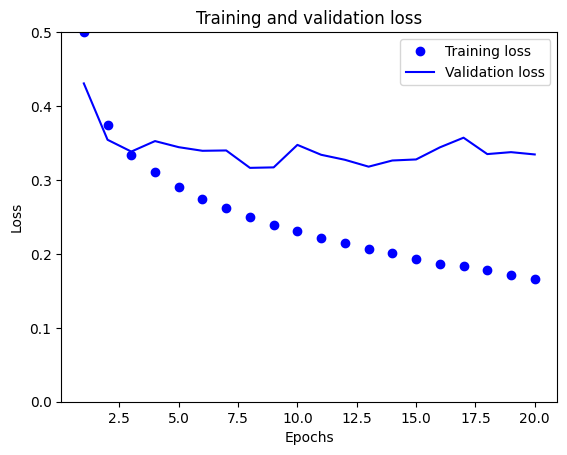

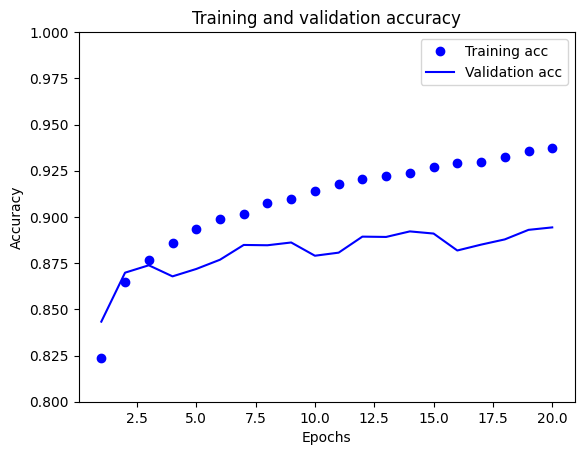

In [10]:
import matplotlib.pyplot as plt
def plot_result(data):
  history_dict = data.history
  loss_values = history_dict['loss']
  val_loss_values = history_dict['val_loss']

  epochs = range(1, len(history_dict['accuracy']) + 1)

  plt.plot(epochs, loss_values, 'bo', label='Training loss')
  plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.ylim(0, 0.5)
  plt.legend()
  plt.show()

  plt.clf()
  val_acc_values = history_dict['val_accuracy']
  plt.plot(epochs, history_dict['accuracy'], 'bo', label='Training acc')
  plt.plot(epochs, history_dict['val_accuracy'], 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.ylim(0.8, 1.0)
  plt.legend()

plot_result(history)

In [12]:
for key, value in history.history.items():
    print(key, round(value[-1], 2))

accuracy 0.94
loss 0.17
val_accuracy 0.89
val_loss 0.33
